In [1]:
# Install required packages.
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
os.environ['TORCH'] = torch.__version__
print(f"torch version : {torch.__version__}")


%matplotlib widget
# %matplotlib inline

from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import utils
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

torch version : 2.0.1+cu117


/home/xsalon/anaconda3/envs/pyG-primary/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

In [ ]:
from data import FaissGenerator

# Uncomment if needed

generator = FaissGenerator('mnist_784', nn=100, cosine_metric=True)
X, y, distances, indexes = generator.run()
generator.save('mnist_784_nn100_cosine.pkl.lz4')
X, y, distances, indexes = FaissGenerator.load('mnist_784_nn100_cosine.pkl.lz4')
y = y.astype(np.int32)

In [ ]:
print(X.shape)
print(y.shape)
print(distances.shape)
print(indexes.shape)

In [ ]:
from torch_geometric.data import Data, Dataset
from numpy.random import default_rng


def getDataGraph(data_size, K):
    idxs = default_rng().choice(y.shape[0], size=data_size, replace=False)

    edge_index = np.concatenate([indexes[idxs][:, [0, k]] for k in range(K)])
    g = nx.Graph()
    g.add_edges_from(edge_index)
    idxs = g.nodes
    reindexed_graph = nx.relabel.convert_node_labels_to_integers(g, first_label=0, ordering='default')

    d0 = Data(x = torch.Tensor(X[idxs]),
    pos = torch.Tensor(X[idxs]),
    y = torch.LongTensor(y[idxs]),
    edge_index = torch.LongTensor(np.array(reindexed_graph.edges)).T,
    edge_attr = torch.Tensor(np.concatenate([distances[idxs][:, [0, k]] for k in range(K)]).T))

    # assert d0.edge_index.max() + 1 == d0.x.shape[0]
    assert d0.edge_index.max() + 1 <= d0.x.shape[0]
    return d0

In [3]:
DATAS_NO = 10


In [ ]:

dataset = [getDataGraph(4000, 10) for _ in range(DATAS_NO)]
d0 = dataset[0]

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset[0].num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, 10)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

GCN()

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN().to(device)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    data = data.to(device)
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    # loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.

    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

H = [[] for _ in range(len(dataset))]
C = [None for _ in range(len(dataset))]

EPOCHS=10000
for epoch in range(EPOCHS):
    for i, data in enumerate(dataset):
        loss, h = train(data)
        H[i].append(h.detach().cpu())
        if C[i] is None:
            C[i] = data.y.cpu().numpy()
    
    if epoch % int(0.1 * EPOCHS) == 0:
        print(f"{epoch} / {EPOCHS}")

H = list(map(lambda hl: np.stack(hl), H))

for i, (h, c) in enumerate(zip(H, C)):
    np.save(f'tmp_H-{i}.npy', h)
    np.save(f'tmp_C-{i}.npy', c)

Button(description='Run anim', style=ButtonStyle())

Button(description='Stop anim', style=ButtonStyle())

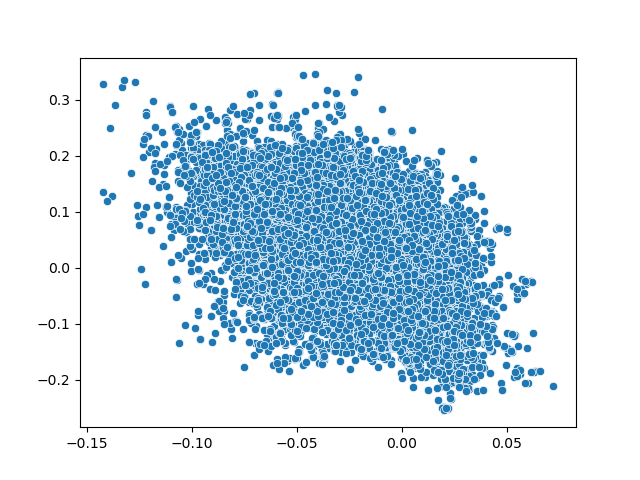

In [9]:
p = '/home/xsalon/studia/wizualizacje/gnn-visualization/data/mnist'

H = [np.load(f'{p}/tmp_H-{i}.npy') for i in range(DATAS_NO)]
C = [np.load(f'{p}/tmp_C-{i}.npy') for i in range(DATAS_NO)]

a = utils.EmbeddingsScatterAnimation(H[0], C=C[0], xlim=(0, 1), ylim=(0, 1))

In [12]:
a.anim.save('asdf.gif',  writer='imagemagick')

KeyboardInterrupt: 